<a href="https://colab.research.google.com/github/aesteki/Alcohol-Effects-on-Study/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset and Model**

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source [here](http://www3.dsi.uminho.pt/pcortez/student.pdf)).

Here, to simplify the problem, we measure training and test accuracy values incuding G1 and G2 as features of the model. To better also understand the accuracy of the results, we measure the Root Mean Squared Error (RMSE) between predicted values and the acutal target points. Moreover, two popular models Decision Tree (DT) and Gradient Boosted Decision Tree (GBDT) are compared here. The results for the DT model are taken from the reference paper where a 1.94 RMSE value is achieved. We tune our GBDT model to see whether this value can be decreased.

In the following, we first import the data from gitHub, then some prerpocessing steps are performed such as turning string data structures into continuous values to fit for DR models, and then training is conducted. For brevity, the best model found for DT is depicted here without showing the process. However, we show how hyperparamters of the GBDT model are tuned. A brief comparison between the two models is provided at the end that shows the dominancy of the GBDT model over the DT model. Since the reference paper has optimized the DT model, the results of GBDT are compared to the on there.


In [38]:
pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
# We upload teh dataset and store Maths and Portuguese in two variables "maths" and "port"
import pandas as pd
import numpy as np
import numpy
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from math import sqrt
import matplotlib.pyplot as plt
url_maths = 'https://raw.githubusercontent.com/aesteki/Alcohol-Effects-on-Study/main/Maths.csv'
url_port = 'https://raw.githubusercontent.com/aesteki/Alcohol-Effects-on-Study/main/Portuguese.csv'
maths = pd.read_csv(url_maths)
port = pd.read_csv(url_port)

In [49]:
# replacing values

maths['school'].replace(['GP', 'MS'], [0, 1], inplace=True)
maths['sex'].replace(['M', 'F'], [0, 1], inplace=True)
maths['address'].replace(['U', 'R'], [0, 1], inplace=True)
maths['Pstatus'].replace(['A', 'T'], [0, 1], inplace=True)
maths['famsize'].replace(['GT3', 'LE3'], [0, 1], inplace=True)
maths['Mjob'].replace(['at_home', 'health', 'other', 'services', 'teacher'], [0, 1, 2, 3, 4], inplace=True)
maths['Fjob'].replace(['at_home', 'health', 'other', 'services', 'teacher'], [0, 1, 2, 3, 4], inplace=True)
maths['reason'].replace(['course', 'other', 'home', 'reputation'], [0, 1, 2, 3], inplace=True)
maths['guardian'].replace(['mother', 'father', 'other'], [0, 1, 2], inplace=True)
maths['schoolsup'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['famsup'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['paid'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['activities'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['nursery'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['higher'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['internet'].replace(['yes', 'no'], [0, 1], inplace=True)
maths['romantic'].replace(['yes', 'no'], [0, 1], inplace=True)

port['school'].replace(['GP', 'MS'], [0, 1], inplace=True)
port['sex'].replace(['M', 'F'], [0, 1], inplace=True)
port['address'].replace(['U', 'R'], [0, 1], inplace=True)
port['Pstatus'].replace(['A', 'T'], [0, 1], inplace=True)
port['famsize'].replace(['GT3', 'LE3'], [0, 1], inplace=True)
port['Mjob'].replace(['at_home', 'health', 'other', 'services', 'teacher'], [0, 1, 2, 3, 4], inplace=True)
port['Fjob'].replace(['at_home', 'health', 'other', 'services', 'teacher'], [0, 1, 2, 3, 4], inplace=True)
port['reason'].replace(['course', 'other', 'home', 'reputation'], [0, 1, 2, 3], inplace=True)
port['guardian'].replace(['mother', 'father', 'other'], [0, 1, 2], inplace=True)
port['schoolsup'].replace(['yes', 'no'], [0, 1], inplace=True)
port['famsup'].replace(['yes', 'no'], [0, 1], inplace=True)
port['paid'].replace(['yes', 'no'], [0, 1], inplace=True)
port['activities'].replace(['yes', 'no'], [0, 1], inplace=True)
port['nursery'].replace(['yes', 'no'], [0, 1], inplace=True)
port['higher'].replace(['yes', 'no'], [0, 1], inplace=True)
port['internet'].replace(['yes', 'no'], [0, 1], inplace=True)
port['romantic'].replace(['yes', 'no'], [0, 1], inplace=True)

In [45]:

#Decision Tree Model with 100 iterations to average the model training and test accuracy.

iterations = 100
trainAccuracy = 0
testAccuracy = 0
testRMSE = 0
for iter in range(iterations):
  maths = maths.sample(frac = 1)
  port = port.sample(frac = 1)

  data = maths
  featureColumns = data.columns.tolist()
  features = featureColumns[0:32]
  featureCount = len(features)
  target = featureColumns[-1]
  sampleCount = len(data["G3"])

  # Building the matrix for the training dataset

  X = [[0 for _ in range(featureCount)] for _ in range(sampleCount)]
  for j, feature in enumerate(features):
    for i, value in enumerate(data[feature]):
      X[i][j] = value
  
  # Specifying the target values
  
  y = [0 for _ in range(sampleCount)]
  for i, x in enumerate(data[target]):
    y[i] = x
  
  # Split dataset into training set and test set
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
  
  # Create Decision Tree classifer object
  
  clf = DecisionTreeClassifier(max_depth=5)
  
  # Train Decision Tree Classifer
  
  clf = clf.fit(X_train,y_train)
  
  #Predict the response for test dataset
  
  y_pred = clf.predict(X_train)
  trainAccuracy += metrics.accuracy_score(y_train, y_pred)
  
  # Model Accuracy, how often is the regressor correct?
  
  y_pred = clf.predict(X_test)
  testAccuracy += metrics.accuracy_score(y_test, y_pred)
  testRMSE += sqrt(mean_squared_error(y_test, y_pred))

trainAccuracy /= iterations
testAccuracy /= iterations
testRMSE /= iterations
print("Train Accuracy: %"+str(100*trainAccuracy))
print("Test Accuracy: %"+str(100*testAccuracy))
print("Test RMSE: "+str(testRMSE))

Train Accuracy: %64.96835443037973
Test Accuracy: %42.227848101265806
Test RMSE: 2.180265557940999


In [ ]:
from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(clf, out_file=None, feature_names=features))

We now train a model using the popular novel method Gradient Boosted Decision Trees (GBDT). This new method of course needs tuning just like other models. Therefore, we seek to find the optimum maximum depth of the tree and minimum child weights in the next two set of iterations. For each hyperparamter different values for these two hyperparatmers are assigned, for 100 iterations the ttraining and test accuracy, and RMSE of the model are measured in average, and the final results are compared. The model with the highest test accuracy is then chosen.

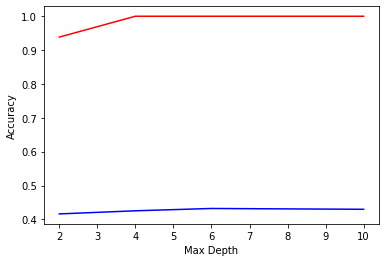

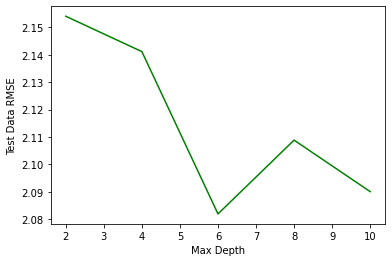

In [73]:
from xgboost import XGBClassifier

#Gradient Boosted Decision Tree Model with 100 iterations while optimizing the hyperparamter max_depth

iterations = 5
rounds = 100
trainAccuracy = [0 for _ in range(iterations)]
testAccuracy = [0 for _ in range(iterations)]
testRMSE = [0 for _ in range(iterations)]
for iter in range(iterations):
  for round in range(rounds):
    data = maths.values

    # Split dataset into input and output columns

    X, y = data[:, :-1], data[:, -1]
    X, y = shuffle(X, y)

    # Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
    model = XGBClassifier(max_depth=(iter+1)*2)
    model.fit(X_train, y_train)

    #Predict the response for test dataset

    y_pred = model.predict(X_train)
    trainAccuracy[iter] += metrics.accuracy_score(y_train, y_pred)

    # Model Accuracy, how often is the regressor correct?

    y_pred = model.predict(X_test)
    testAccuracy[iter] += metrics.accuracy_score(y_test, y_pred)
    testRMSE[iter] += sqrt(mean_squared_error(y_test, y_pred))
  trainAccuracy[iter] /= rounds
  testAccuracy[iter] /= rounds
  testRMSE[iter] /= rounds

plt.plot([(i+1)*2 for i in range(iterations)], trainAccuracy, 'r')
plt.plot([(i+1)*2 for i in range(iterations)], testAccuracy, 'b')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()
plt.plot([(i+1)*2 for i in range(iterations)], testRMSE, 'g')
plt.xlabel("Max Depth")
plt.ylabel("Test Data RMSE")
plt.show()

We can see in the results above that with max_depth=6,8,10 we get almost the same percentage for the test accuracy. Therefore, we look at the RMSE value for the test data, and since at max_depth=6, we have the lowest RMSE, we choose this value to continue with. Next, we measure which value min_child_weight gives us the best test accuracy.

In [ ]:
from xgboost import XGBClassifier

#Gradient Boosted Decision Tree Model with 100 iterations while optimizing the hyperparamter max_depth

iterations = 10
rounds = 100
trainAccuracy = [0 for _ in range(iterations)]
testAccuracy = [0 for _ in range(iterations)]
testRMSE = [0 for _ in range(iterations)]
for iter in range(iterations):
  for round in range(rounds):
    data = maths.values

    # Split dataset into input and output columns

    X, y = data[:, :-1], data[:, -1]
    X, y = shuffle(X, y)

    # Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
    model = XGBClassifier(max_depth=6, min_child_weight=(iter+1)*2)
    model.fit(X_train, y_train)

    #Predict the response for test dataset

    y_pred = model.predict(X_train)
    trainAccuracy[iter] += metrics.accuracy_score(y_train, y_pred)

    # Model Accuracy, how often is the regressor correct?

    y_pred = model.predict(X_test)
    testAccuracy[iter] += metrics.accuracy_score(y_test, y_pred)
    testRMSE[iter] += sqrt(mean_squared_error(y_test, y_pred))
  trainAccuracy[iter] /= rounds
  testAccuracy[iter] /= rounds
  testRMSE[iter] /= rounds

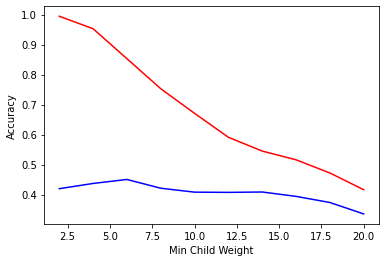

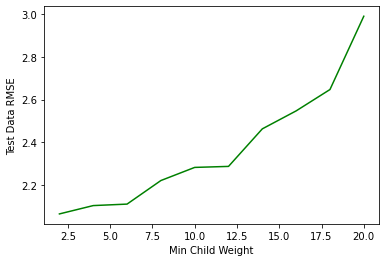

In [75]:
plt.plot([(i+1)*2 for i in range(iterations)], trainAccuracy, 'r')
plt.plot([(i+1)*2 for i in range(iterations)], testAccuracy, 'b')
plt.xlabel("Min Child Weight")
plt.ylabel("Accuracy")
plt.show()
plt.plot([(i+1)*2 for i in range(iterations)], testRMSE, 'g')
plt.xlabel("Min Child Weight")
plt.ylabel("Test Data RMSE")
plt.show()

The result above indicates that the ebst test accuracy occurs while choosing min_child_weight=6. Since we need faster simulations, by. incorporating the hypermatater tree_method='hist', and some other manipulations in the model, we traing the final model as below.

In [83]:
from xgboost import XGBClassifier

#Gradient Boosted Decision Tree Model with 100 iterations to average the model training and test accuracy.

iterations = 100
trainAccuracy = 0
testAccuracy = 0
testRMSE = 0
for iter in range(iterations):
  data = maths.values

  # Split dataset into input and output columns

  X, y = data[:, :-1], data[:, -1]
  X, y = shuffle(X, y)

  # Split dataset into training set and test set

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
  model = XGBClassifier(max_depth=6, min_child_weight=6, tree_method='hist', gamma=2, subsample=0.8, colsample_bytree=0.8)
  model.fit(X_train, y_train)

  #Predict the response for test dataset

  y_pred = model.predict(X_train)
  trainAccuracy += metrics.accuracy_score(y_train, y_pred)

  # Model Accuracy, how often is the regressor correct?

  y_pred = model.predict(X_test)
  testAccuracy += metrics.accuracy_score(y_test, y_pred)
  testRMSE += sqrt(mean_squared_error(y_test, y_pred))
trainAccuracy /= iterations
testAccuracy /= iterations
testRMSE /= iterations
print("Train Accuracy: %"+str(100*trainAccuracy))
print("Test Accuracy: %"+str(100*testAccuracy))
print("Test RMSE: "+str(testRMSE))

Train Accuracy: %64.24050632911393
Test Accuracy: %56.9620253164557
Test RMSE: 1.3547852368455613


In summary we have the final results for the DT and GBDT model as following:
DT:

*   DT of the current work:
        Training Accuracy = %64.97
        Test Accuracy = %42.23
        RMSE = 2.18

*   DT of the reference paper:
        Training Accuracy = N/A
        Test Accuracy = N/A
        RMSE = 1.94

*   GBDT of the current work:
        Training Accuracy = 64.24
        Test Accuracy = 56.96
        RMSE = 1.35

We can observe that the GBDT model has a %14.73 increase in test accuracy compared to the DT model we formed in the current work while maintaining 0.6 decrease in RMSE compared to the DT model achieved by the reference paper. This shows the dominancy of the GBDT model over the DT model.

